In [1]:
import os
import warnings
warnings.filterwarnings("ignore")

if not os.path.exists('cell_images'):
    !pip install -U -q torch_snippets

from torch_snippets import *

In [2]:
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

DATA_PATH = Path('/kaggle/input/cell-images-for-detecting-malaria/cell_images/')
INFECTED_PATH = DATA_PATH / 'Parasitized'
UNINFECTED_PATH = DATA_PATH / 'Uninfected'
id2int = {'Parasitized': 0, 'Uninfected': 1}

# Define the transformations to be done on top of the images
trn_tfms = T.Compose([
    T.ToPILImage(),
    T.Resize(128),
    T.CenterCrop(128),
    T.ColorJitter(brightness=(0.95, 1.05),
                  contrast=(0.95, 1.05),
                  saturation=(0.95, 1.05),
                  hue=0.05),
    T.RandomAffine(5, translate=(0.01, 0.1)),
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5],
                std=[0.5, 0.5, 0.5]),
])

val_tfms = T.Compose([
    T.ToPILImage(),
    T.Resize(128),
    T.CenterCrop(128),
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5],
                std=[0.5, 0.5, 0.5]),
])

class MalariaImages(Dataset):
    """Dataset class for Malaria images."""
    def __init__(self, files, transform=None):
        """
        Initialize the MalariaImages dataset.

        Args:
            files (list): List of image file paths.
            transform (torchvision.transforms.Compose): Image transformation pipeline.
        """
        self.files = files
        self.transform = transform

    def __len__(self):
        """Get the length of the dataset."""
        return len(self.files)

    def __getitem__(self, ix):
        """Get an item from the dataset."""
        fpath = self.files[ix]
        clss = fpath.parent.name
        img = cv2.imread(str(fpath), 1)
        return img, clss

    def choose(self):
        """Randomly select an item from the dataset."""
        return self[np.random.randint(len(self))]

    def collate_fn(self, batch):
        """Collate function for the dataset."""
        _imgs, classes = list(zip(*batch))
        if self.transform:
            imgs = [self.transform(img)[None] for img in _imgs]
        classes = [torch.tensor([id2int[clss]]) for clss in classes]
        imgs, classes = [torch.cat(i).to(device) for i in [imgs, classes]]
        return imgs, classes, _imgs

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
all_files = list(DATA_PATH.glob('*/*.png'))
np.random.seed(10)
np.random.shuffle(all_files)

train_files, testval_files = train_test_split(all_files, test_size=0.2, random_state=1)
val_files, test_files = train_test_split(testval_files, test_size=0.5, random_state=1)

train_ds = MalariaImages(train_files, transform=trn_tfms)
val_ds = MalariaImages(val_files, transform=val_tfms)
test_ds = MalariaImages(test_files, transform=val_tfms)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, collate_fn=train_ds.collate_fn)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=False, collate_fn=val_ds.collate_fn)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=False, collate_fn=test_ds.collate_fn)

def convBlock(ni, no):
    """Create a convolutional block."""
    return nn.Sequential(
        nn.Dropout(0.2),
        nn.Conv2d(ni, no, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(no),
        nn.MaxPool2d(2),
    )

class MalariaClassifier(nn.Module):
    """Malaria classifier model."""
    def __init__(self):
        """Initialize the MalariaClassifier model."""
        super().__init__()
        self.model = nn.Sequential(
            convBlock(3, 64),
            convBlock(64, 64),
            convBlock(64, 128),
            convBlock(128, 256),
            convBlock(256, 512),
            convBlock(512, 64),
            nn.Flatten(),
            nn.Linear(256, 256),
            nn.Dropout(0.2),
            nn.ReLU(inplace=True),
            nn.Linear(256, len(id2int))
        )
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        """Forward pass of the model."""
        return self.model(x)

    def compute_metrics(self, preds, targets):
        """Compute the loss and accuracy metrics."""
        loss = self.loss_fn(preds, targets)
        acc = (torch.max(preds, 1)[1] == targets).float().mean()
        return loss, acc

def train_batch(model, data, optimizer, criterion):
    """Train the model on a batch of data."""
    model.train()
    ims, labels, _ = data
    _preds = model(ims)
    optimizer.zero_grad()
    loss, acc = criterion(_preds, labels)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    """Validate the model on a batch of data."""
    model.eval()
    ims, labels, _ = data
    _preds = model(ims)
    loss, acc = criterion(_preds, labels)
    return loss.item(), acc.item()

model = MalariaClassifier().to(device)
criterion = model.compute_metrics
optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 10
log = Report(n_epochs)

best_val_loss = float('inf')
best_model_path = 'best_model.pth'

for ex in range(n_epochs):
    N = len(train_dl)
    for bx, data in enumerate(train_dl):
        loss, acc = train_batch(model, data, optimizer, criterion)
        log.record(ex + (bx + 1) / N, trn_loss=loss, trn_acc=acc, end='\r')

    N = len(val_dl)
    val_loss_total = 0
    val_acc_total = 0
    val_preds = []
    val_targets = []
    for bx, data in enumerate(val_dl):
        loss, acc = validate_batch(model, data, criterion)
        val_loss_total += loss
        val_acc_total += acc
        preds = torch.argmax(model(data[0]), dim=1).cpu().numpy()
        targets = data[1].cpu().numpy()
        val_preds.extend(preds)
        val_targets.extend(targets)

    val_loss_avg = val_loss_total / N
    val_acc_avg = val_acc_total / N

    log.record(ex + 1, val_loss=val_loss_avg, val_acc=val_acc_avg, end='\n')

    if val_loss_avg < best_val_loss:
        best_val_loss = val_loss_avg
        torch.save(model.state_dict(), best_model_path)
        torch.save(model, "best_model_full.pth")

# Save the model in a useful format
torch.save(model.state_dict(), 'malaria_classifier_model.pth')

# Save the entire model
torch.save(model, 'malaria_classifier_model_full.pth')

EPOCH: 1.000  val_loss: 0.189  val_acc: 0.943  (402.54s - 3622.89s remaining)
EPOCH: 2.000  val_loss: 0.155  val_acc: 0.951  (577.13s - 2308.53s remaining)
EPOCH: 3.000  val_loss: 0.168  val_acc: 0.948  (752.58s - 1756.01s remaining)
EPOCH: 4.000  val_loss: 0.162  val_acc: 0.952  (927.29s - 1390.94s remaining)
EPOCH: 5.000  val_loss: 0.145  val_acc: 0.954  (1102.59s - 1102.59s remaining)
EPOCH: 6.000  val_loss: 0.156  val_acc: 0.948  (1281.60s - 854.40s remaining))
EPOCH: 7.000  val_loss: 0.133  val_acc: 0.954  (1457.26s - 624.54s remaining)
EPOCH: 8.000  val_loss: 0.135  val_acc: 0.952  (1635.28s - 408.82s remaining)
EPOCH: 9.000  val_loss: 0.135  val_acc: 0.954  (1818.59s - 202.07s remaining)
EPOCH: 10.000  val_loss: 0.129  val_acc: 0.954  (2013.63s - 0.00s remaining))


In [3]:
model.load_state_dict(torch.load(best_model_path))

# automatic confusion matrix

test_loss_total = 0
test_acc_total = 0
test_preds = []
test_targets = []
for bx, data in enumerate(test_dl):
    loss, acc = validate_batch(model, data, criterion)
    test_loss_total += loss
    test_acc_total += acc
    preds = torch.argmax(model(data[0]), dim=1).cpu().numpy()
    targets = data[1].cpu().numpy()
    test_preds.extend(preds)
    test_targets.extend(targets)

test_loss_avg = test_loss_total / len(test_dl)
test_acc_avg = test_acc_total / len(test_dl)

cm = confusion_matrix(test_targets, test_preds)
print("Confusion Matrix:")
print(cm)

target_names = ['Parasitized', 'Uninfected']
classification_rep = classification_report(test_targets, test_preds, target_names=target_names)
print("Classification Report:")
print(classification_rep)


Confusion Matrix:

[[1254   98]
 [  24 1380]]

Classification Report:

precision    recall  f1-score   support

 Parasitized       0.98      0.93      0.95      1352
  Uninfected       0.93      0.98      0.96      1404

    accuracy                           0.96      2756
   macro avg       0.96      0.96      0.96      2756
weighted avg       0.96      0.96      0.96      2756

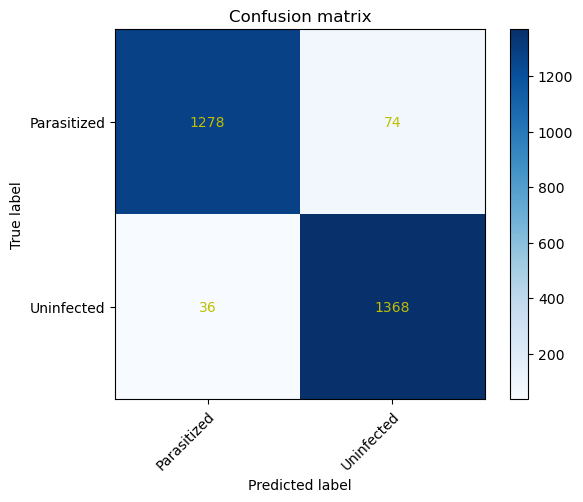

100%|██████████| 111/111 [00:00<00:00, 422.44it/s]


[06/21/23 11:09:43] INFO     metric val_loss was not fully recorded. Plotting final ]8;id=580663;file:///opt/conda/lib/python3.10/site-packages/torch_snippets/torch_loader.py\torch_loader.py]8;;\:]8;id=737835;file:///opt/conda/lib/python3.10/site-packages/torch_snippets/torch_loader.py#plot_epochs:235\plot_epochs:235]8;;\
                             epochs using last recorded value                                                      

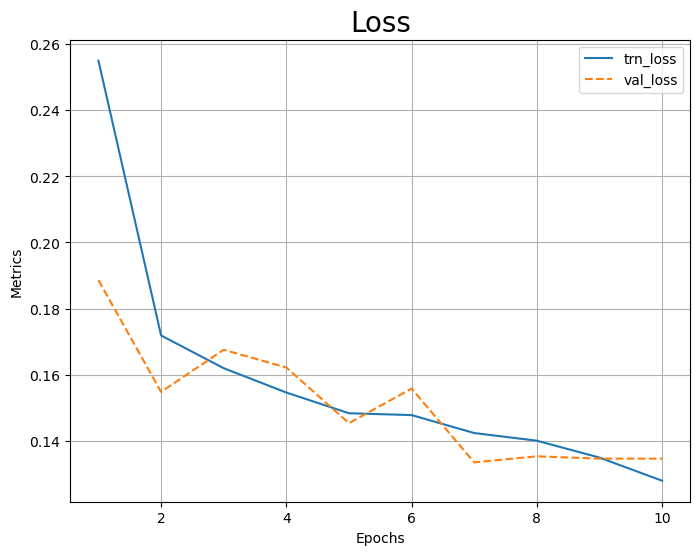

100%|██████████| 111/111 [00:00<00:00, 412.41it/s]


[06/21/23 11:09:44] INFO     metric val_acc was not fully recorded. Plotting final  ]8;id=152588;file:///opt/conda/lib/python3.10/site-packages/torch_snippets/torch_loader.py\torch_loader.py]8;;\:]8;id=771283;file:///opt/conda/lib/python3.10/site-packages/torch_snippets/torch_loader.py#plot_epochs:235\plot_epochs:235]8;;\
                             epochs using last recorded value                                                      

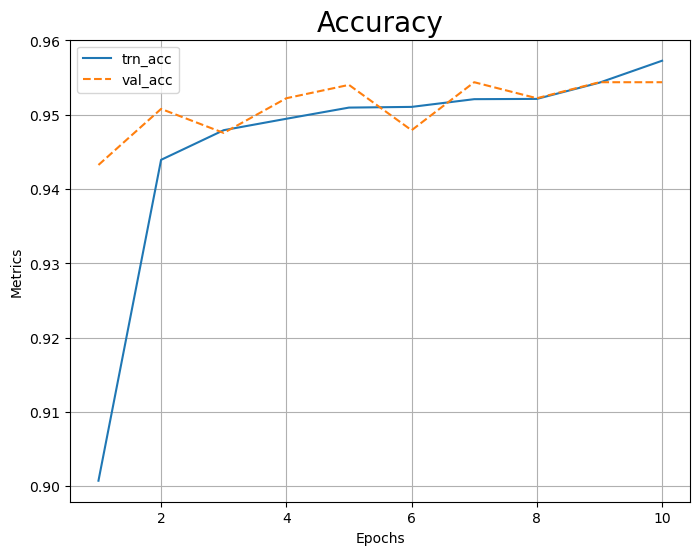

In [4]:
# manual confusion matrix


# Set input image metadata
input_size = (3, 224, 224)  # Assuming RGB images of size 224x224


# Define the class names based on the id2int mapping
class_names = ['Parasitized', 'Uninfected']


# Load the best model
best_full_model = MalariaClassifier().to(device)
best_full_model.load_state_dict(torch.load(best_model_path))
best_full_model.to(device)


# Create empty lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Loop over batches in test dataloader, make predictions, and append true and predicted labels to lists
for batch in test_dl:
    images, labels = batch[0].to(device), batch[1].to(device)
    with torch.no_grad():
        outputs = best_full_model(images)
        _, predicted = torch.max(outputs.data, 1)
    true_labels.extend(labels.cpu().numpy())
    predicted_labels.extend(predicted.cpu().numpy())
    
        
# Calculate confusion matrix, precision, and recall
conf_matrix = confusion_matrix(true_labels, predicted_labels)
precision = conf_matrix.diagonal() / conf_matrix.sum(axis=0)
recall = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

# Create figure and axis objects
fig, ax = plt.subplots()

# Create heatmap of confusion matrix
im = ax.imshow(conf_matrix, cmap='Blues')

# Add colorbar to heatmap
cbar = ax.figure.colorbar(im, ax=ax)

# Set tick labels and axis labels
ax.set_xticks(np.arange(len(class_names)))
ax.set_yticks(np.arange(len(class_names)))
ax.set_xticklabels(class_names)
ax.set_yticklabels(class_names)
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')

# Rotate tick labels and set alignment
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Add text annotations to heatmap
for i in range(len(class_names)):
    for j in range(len(class_names)):
        if conf_matrix[i, j] >= 10:  # Modify threshold value as needed
            text = ax.text(j, i, conf_matrix[i, j],
                           ha="center", va="center", color="y")
        else:
            text = ax.text(j, i, "",
                           ha="center", va="center", color="y")

# Add title to plot
ax.set_title("Confusion matrix")

# Show plot
plt.show()

# Plot the training and validation graphs
log.plot_epochs(['trn_loss', 'val_loss'], title="Loss")
log.plot_epochs(['trn_acc', 'val_acc'], title="Accuracy")

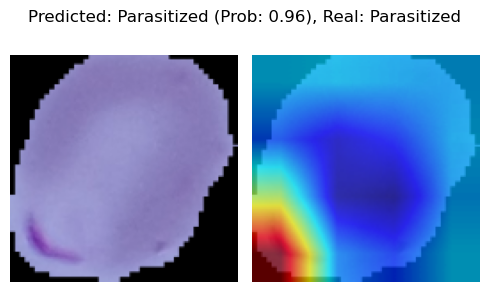

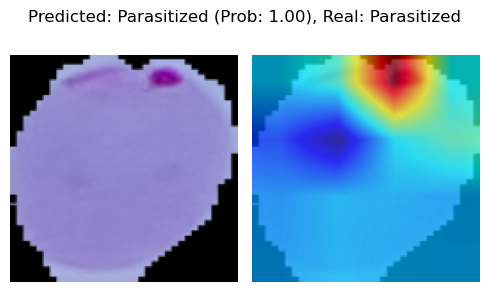

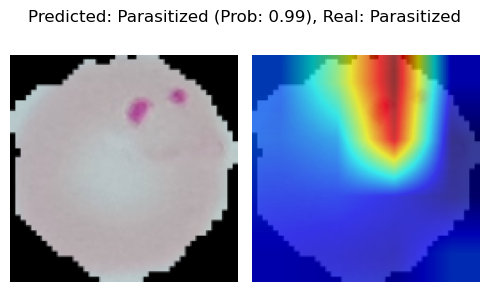

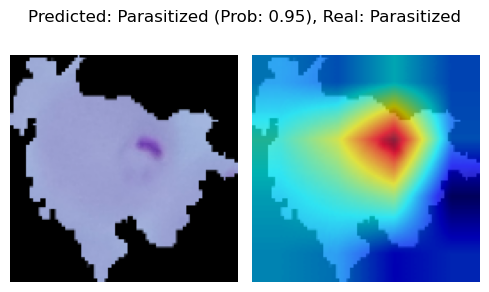

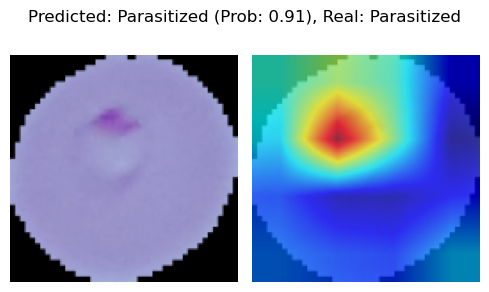

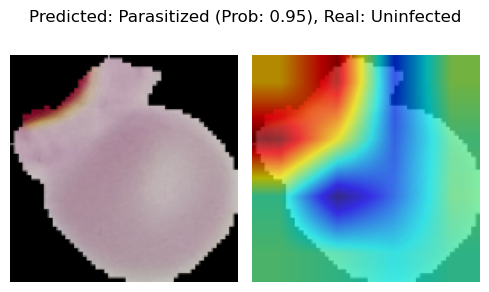

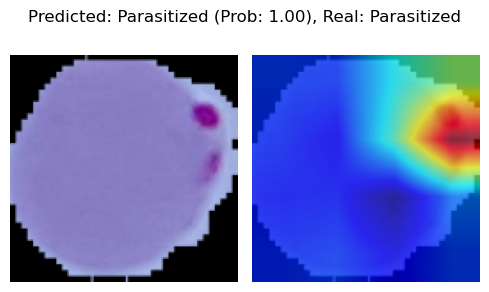

In [5]:
SZ = 128

def upsample_heatmap(map, img):
    m, M = map.min(), map.max()
    map = 255 * ((map - m) / (M - m))
    map = np.uint8(map)
    map = cv2.resize(map, (SZ, SZ))
    map = cv2.applyColorMap(255 - map, cv2.COLORMAP_JET)
    map = np.uint8(map)
    map = np.uint8(map * 0.7 + img * 0.3)
    return map

im2fmap = nn.Sequential(*(list(model.model[:5].children()) + list(model.model[5][:2].children())))

def im2gradCAM(x):
    model.eval()
    logits = model(x)
    heatmaps = []
    activations = im2fmap(x)
    pred = logits.max(-1)[-1]
    model.zero_grad()
    logits[0, pred].backward(retain_graph=True)
    pooled_grads = model.model[-6][1].weight.grad.data.mean((1, 2, 3))
    for i in range(activations.shape[1]):
        activations[:, i, :, :] *= pooled_grads[i]
    heatmap = torch.mean(activations, dim=1)[0].cpu().detach()
    return heatmap, pred.item(), logits[0]

N = 20
test_dl = DataLoader(test_ds, batch_size=N, shuffle=True, collate_fn=test_ds.collate_fn)
x, y, z = next(iter(test_dl))

for i in range(N):
    image = resize(z[i], SZ)
    heatmap, pred, logits = im2gradCAM(x[i:i+1])
    real_label = y[i].item()
    pred_label = 0 if pred == 0 else 1
    pred_prob = torch.softmax(logits.unsqueeze(0), dim=-1)[0, pred_label].item()
    label_names = ['Parasitized', 'Uninfected']
    pred_name = label_names[pred_label]
    real_name = label_names[real_label]
    if pred_name == 'Uninfected':
        continue
    heatmap = upsample_heatmap(heatmap, image)
    subplots([image, heatmap], nc=2, figsize=(5, 3), suptitle=f"Predicted: {pred_name} (Prob: {pred_prob:.2f}), Real: {real_name}")


In [6]:
!pip install pillow -q

In [7]:
!pip install fpdf -q

In [13]:
%%writefile app.py

import streamlit as st
import cv2
import torch
import numpy as np
import torch.nn as nn

from torchvision import transforms as T
from PIL import Image
from fpdf import FPDF


SZ = 128

trn_tfms = T.Compose([
    T.ToPILImage(),
    T.Resize(SZ),
    T.CenterCrop(SZ),
    T.ColorJitter(brightness=(0.95, 1.05),
                  contrast=(0.95, 1.05),
                  saturation=(0.95, 1.05),
                  hue=0.05),
    T.RandomAffine(5, translate=(0.01, 0.1)),
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5],
                std=[0.5, 0.5, 0.5]),
])

def convBlock(ni, no):
    """Create a convolutional block."""
    return nn.Sequential(
        nn.Dropout(0.2),
        nn.Conv2d(ni, no, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(no),
        nn.MaxPool2d(2),
    )

class MalariaClassifier(nn.Module):
    """Malaria classifier model."""
    def __init__(self):
        """Initialize the MalariaClassifier model."""
        super().__init__()
        self.model = nn.Sequential(
            convBlock(3, 64),
            convBlock(64, 64),
            convBlock(64, 128),
            convBlock(128, 256),
            convBlock(256, 512),
            convBlock(512, 64),
            nn.Flatten(),
            nn.Linear(256, 256),
            nn.Dropout(0.2),
            nn.ReLU(inplace=True),
            nn.Linear(256, len(id2int))
        )
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        """Forward pass of the model."""
        return self.model(x)

    def compute_metrics(self, preds, targets):
        """Compute the loss and accuracy metrics."""
        loss = self.loss_fn(preds, targets)
        acc = (torch.max(preds, 1)[1] == targets).float().mean()
        return loss, acc

# Define the id2int variable here
id2int = ['Parasitized', 'Uninfected']

model = MalariaClassifier()
model_state_dict = torch.load("malaria_classifier_model.pth")
model.load_state_dict(model_state_dict)
model.eval()


im2fmap = nn.Sequential(*(list(model.model[:5].children()) + list(model.model[5][:2].children())))


def preprocess_image(image):
    """convert image to an ndarry"""
    image_array = np.array(image)
    tensor_image = trn_tfms(image_array).unsqueeze(0)
    return tensor_image


def im2gradCAM(x):
    logits = model(x)
    heatmaps = []
    activations = im2fmap(x)
    pred = logits.max(-1)[-1]
    model.zero_grad()
    logits[0, pred].backward(retain_graph=True)
    pooled_grads = model.model[-6][1].weight.grad.data.mean((1, 2, 3))
    for i in range(activations.shape[1]):
        activations[:, i, :, :] *= pooled_grads[i]
    heatmap = torch.mean(activations, dim=1)[0].cpu().detach()
    return heatmap, 'Uninfected' if pred.item() else 'Parasitized'

def upsampleHeatmap(map, img):
    heatmap = cv2.resize(np.array(map), (img.shape[1], img.shape[0]))
    m, M = heatmap.min(), heatmap.max()
    heatmap = 255 * ((heatmap - m) / (M - m))
    heatmap = np.uint8(heatmap)
    heatmap = cv2.applyColorMap(255 - heatmap, cv2.COLORMAP_JET)
    heatmap = np.uint8(heatmap)
    heatmap = np.uint8(heatmap * 0.7 + img * 0.3)
    return heatmap


def resize(image, size):
    return cv2.resize(image, (size, size))

    
def main():
    st.title("Malaria Classifier")
    uploaded_file = st.file_uploader("Upload an image", type=["png", "jpg", "jpeg"])

    if uploaded_file is not None:
        image = Image.open(uploaded_file)
        st.subheader("Original Image")
        resized_image = resize(np.array(image), image.size[0]+20)
        st.image(resized_image, caption="Uploaded Image", use_column_width=True)
        tensor_image = preprocess_image(image)
        heatmap, pred_label = im2gradCAM(tensor_image)
        heatmap_image = upsampleHeatmap(heatmap, np.array(image))

        col1, col2 = st.columns(2)
        col1.subheader("Original Image")
        col1.image(resized_image, caption="Uploaded Image", use_column_width=True)

        col2.subheader("Heat Map")
        col2.image(heatmap_image, caption="Heat Map", use_column_width=True)

        st.subheader("Prediction")
        probabilities = torch.softmax(model(tensor_image), dim=1)[0]
        parasitized_prob = probabilities[0].item() * 100
        uninfected_prob = (probabilities[1].item() * 1000)/10
        st.write(f"Predicted Label: {pred_label}")
        st.write(f"Parasitized Probability: {parasitized_prob:.2f}%")
        st.write(f"Uninfected Probability: {uninfected_prob:.2f}%")


if __name__ == '__main__':
    main()


Overwriting app.py


In [9]:
!pip install streamlit -q -U

In [10]:
!npm install -g npm@9.7.1
!npm install -g localtunnel

m##################) ⠇ reify:npm: http fetch GET 200 https://registry.npmjs.org0ms
removed 3 packages, and changed 64 packages in 22s

27 packages are looking for funding
  run `npm fund` for details
m#################⠂) ⠴ reify:y18n: http fetch GET 200 https://registry.npmjs.or
added 22 packages in 2s

3 packages are looking for funding
  run `npm fund` for details


In [14]:
!wget -q -O - ipv4.icanhazip.com

!streamlit run app.py & npx localtunnel --port 8501 --browser.gatherUsageStats=false

34.170.146.109



  You can now view your Streamlit app in your browser.

  Network URL: http://172.19.2.2:8501
  External URL: http://34.170.146.109:8501

your url is: https://beige-memes-retire.loca.lt
^C
  Stopping...


In [12]:
import pkg_resources

# Get installed package names and versions
packages = [dist.key for dist in pkg_resources.working_set]

# Save package names and versions to requirements.txt file
with open('requirements.txt', 'w') as f:
    for package in packages:
        f.write(f'{package}\n')
